# Has our simulated Markov Chain converged to the stationary distribution?

From our theory of Markov chains, we expect our chains to eventually converge to the stationary distribution, which is also our target distribution.

It is important to check whether we have a valid sample, otherwise any analysis will be totally flawed. 

There are several tests we can perform, some are visual and some are quantitative. These tests are designed to spot problems with our samples, but they are unable to prove that we have the correct distribution; they can only provide evidence that the sample seems reasonable.

In [1]:
%%HTML
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
body{font-size: 120%}
</style>

In [2]:
import logging, sys
logging.disable(sys.maxsize)

In [3]:
import numpy as np
import pymc3 as pm
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.integrate import quad

obs = [-4.]
niter = 5000
nburn = 2000
nchains = 3
with pm.Model() as model:
    m = pm.Uniform('m', lower=0., upper=10.)
    likelihood = pm.Normal('y_obs', mu=m, sigma=2., observed=obs)
    step_1 = pm.Metropolis(S=np.array([.01]))
    step_2 = pm.Metropolis(S=np.array([10]))
    step_3 = pm.Metropolis(S=np.array([2.5]))
    trace_1 = pm.sample(niter, step=step_1, cores=1, tune=0, chains=nchains, random_seed=123)
    trace_2 = pm.sample(niter, step=step_2, cores=1, tune=0, chains=nchains, random_seed=123)
    trace_3 = pm.sample(niter, step=step_3, cores=1, tune=0, chains=nchains, random_seed=123)

/APlin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
100%|██████████| 5000/5000 [00:00<00:00, 8009.31it/s]


In [4]:
np.savetxt('chain_1.txt', trace_1.m)
np.savetxt('chain_2.txt', trace_2.m)
np.savetxt('chain_3.txt', trace_3.m)

# Burn-in
The term *burn-in* describes the practice of throwing away some iterations at the beginning of the MCMC. This is done to cancel out the dependence of the chains on the starting values.

Here we show an example of 3 chains with different starting values.

In [33]:
with model:
    step_new = pm.Metropolis(S=np.array([.2]))
    ex1 = pm.sample(niter, step=step_new, tune=0, chains=1, start={'m': 9}, random_seed=123)
    ex2 = pm.sample(niter, step=step_new, tune=0, chains=1, start={'m': 6}, random_seed=456)
    ex3 = pm.sample(niter, step=step_new, tune=0, chains=1, start={'m': 3}, random_seed=789)

100%|██████████| 5000/5000 [00:00<00:00, 7819.28it/s]


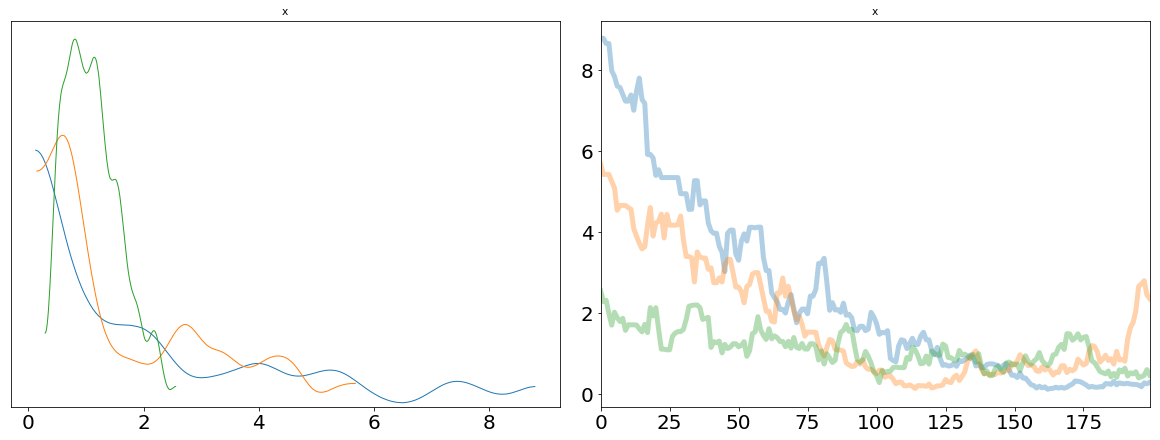

In [34]:
niter_plot = 200
pm.traceplot(np.array([ex1.m[:niter_plot], ex2.m[:niter_plot], ex3.m[:niter_plot]]), figsize=(16, 6),
             textsize=20, trace_kwargs={'linewidth': 5})
pass

In [7]:
t_1 = trace_1[nburn:]
t_2 = trace_2[nburn:]
t_3 = trace_3[nburn:]

# Traceplot
A traceplot shows the history of a parameter value across iterations of the chain. It's easy to spot from the traceplot whether our chains adequately explored the parameter space or not.

We highlight with a red dashed line the end of the burn-in period.

Model 0

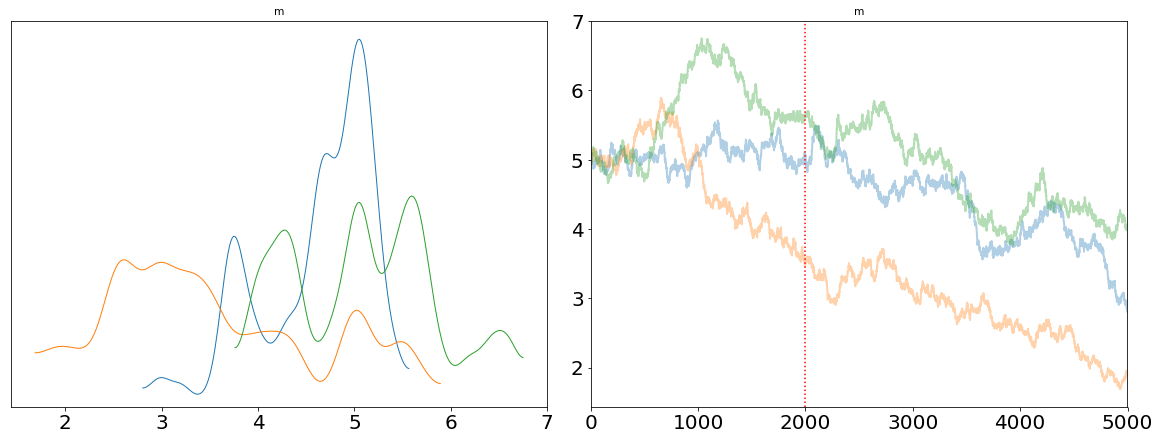

In [36]:
pm.traceplot(trace_1, var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2}, textsize=20)
plt.axvline(nburn, color='r', linestyle=':')
pass

Model 1

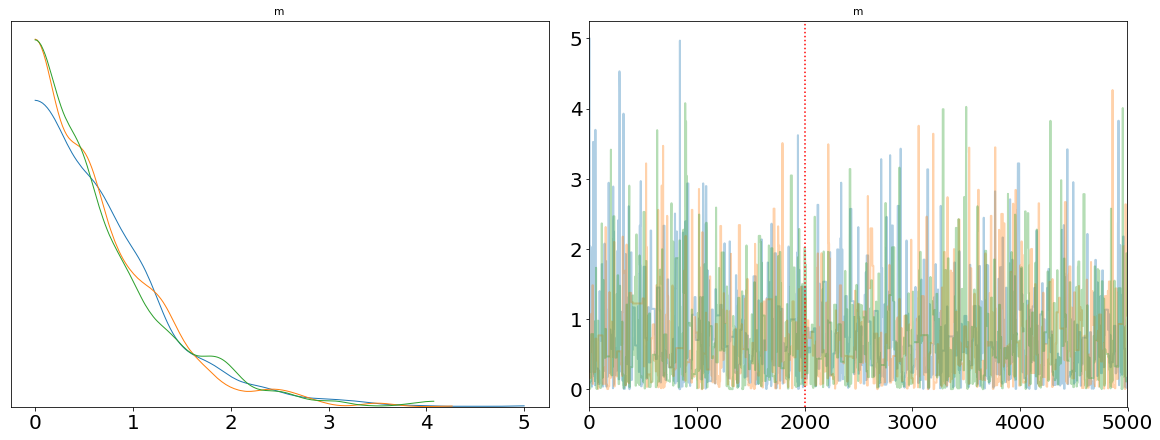

In [37]:
pm.traceplot(trace_2, var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2}, textsize=20)
plt.axvline(nburn, color='r', linestyle=':')
pass

Model 2

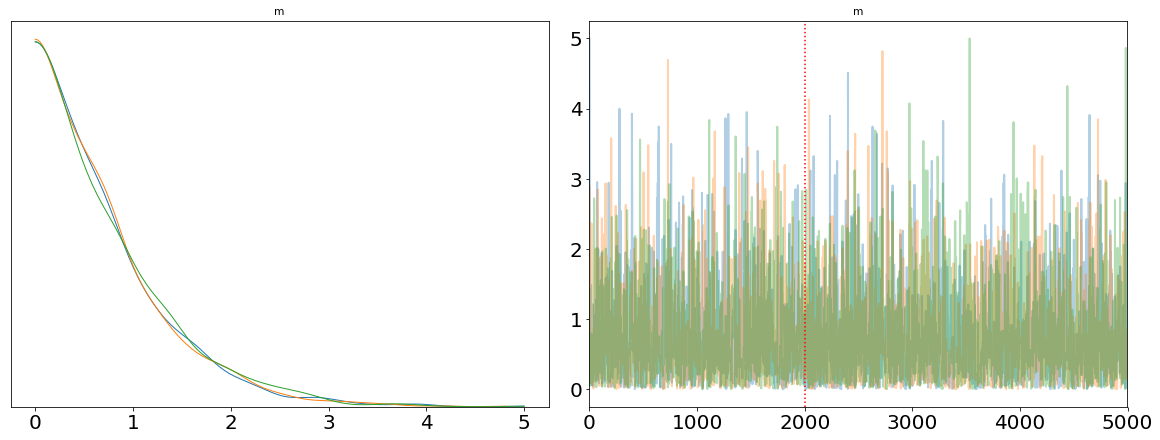

In [38]:
pm.traceplot(trace_3, var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2}, textsize=20)
plt.axvline(nburn, color='r', linestyle=':')
pass

Let us have a closer look at a small portion of 100 iterations from the traceplot. This visualization allows us to spot more adequately the behaviour of each chain.

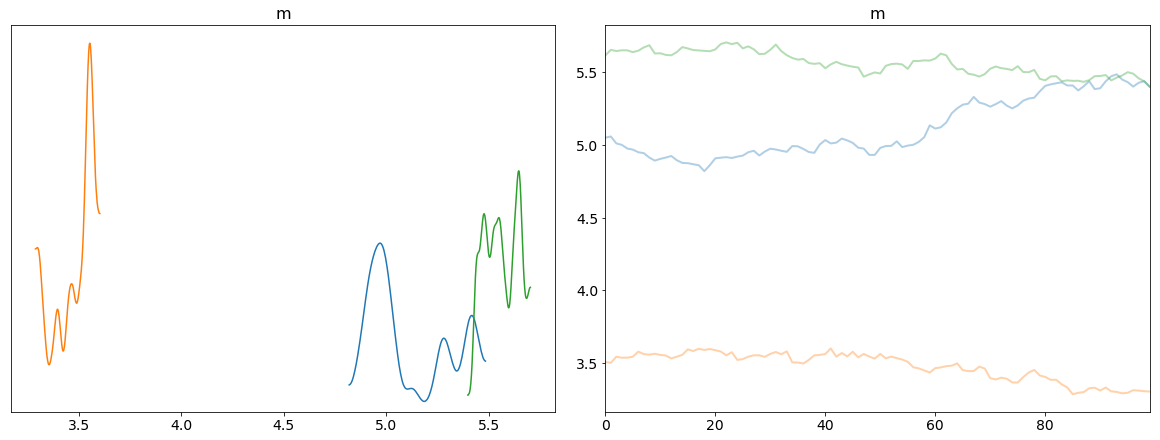

In [11]:
pm.traceplot(trace_1[nburn:nburn+100], var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2})
pass

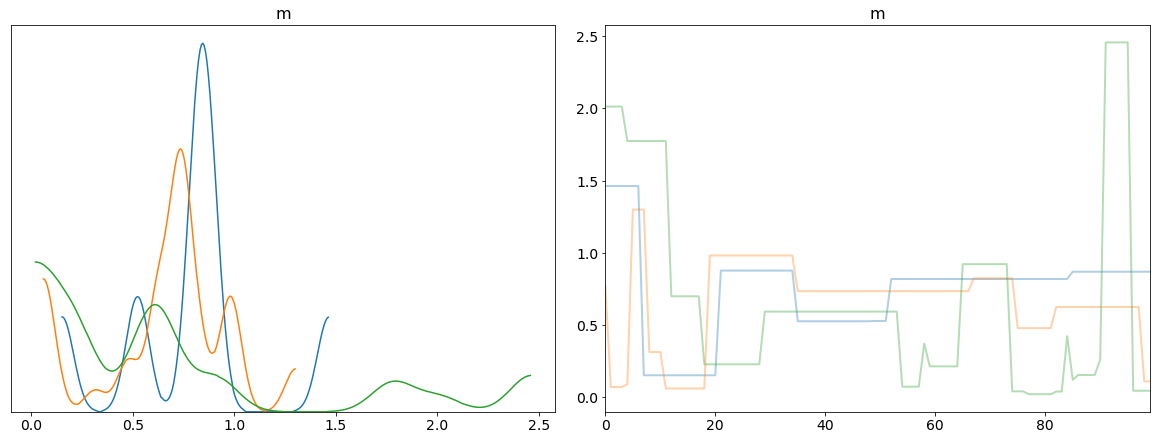

In [12]:
pm.traceplot(trace_2[nburn:nburn+100], var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2})
pass

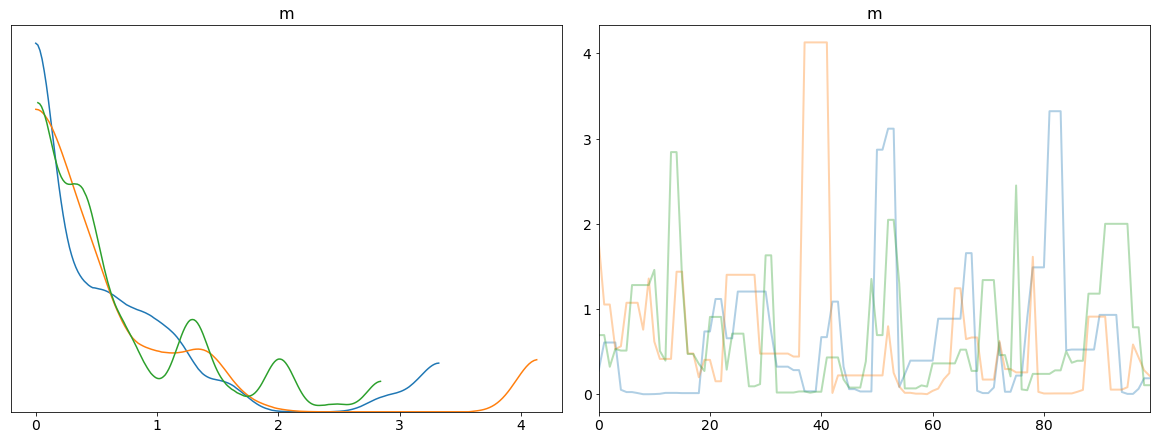

In [13]:
pm.traceplot(trace_3[nburn:nburn+100], var_names=['m'], figsize=(16, 6), trace_kwargs={'linewidth': 2})
pass

# Posterior distribution
In this particular example, we can easily check whether the MCMC did or did not converge to his stationary distribution, which is our target posterior distribution. In fact, we can compute the real distribution analytically and overplot it to the simulated data.

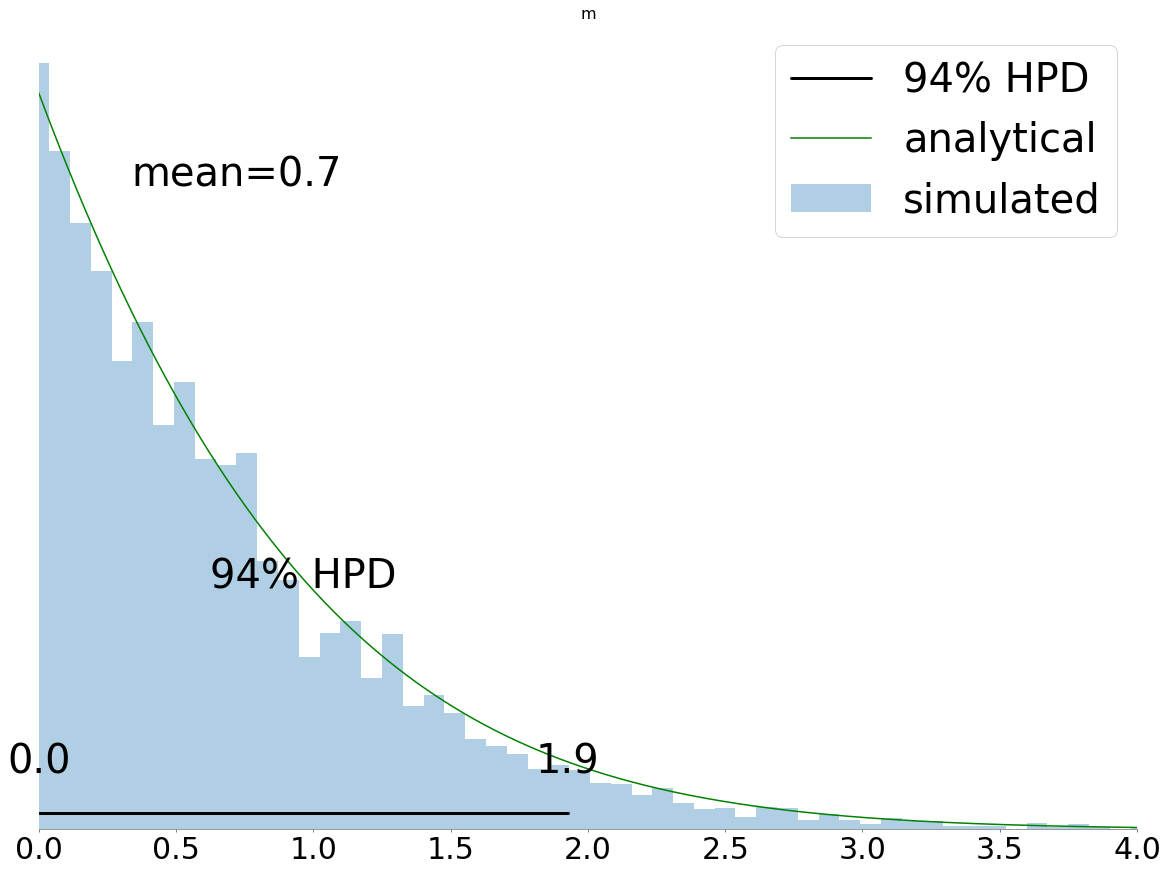

In [23]:
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['axes.labelsize'] = 40
pm.plot_posterior(t_3, var_names=['m'], kind='hist', density=True)
def prior(x):
    return st.uniform.pdf(x, 0., 10.) 
def likelihood(x):
    return st.norm.pdf(x, -4., 2.)
def numerator(x):
    return prior(x)*likelihood(x)
def posterior(x):
    return numerator(x)/quad(numerator, 0., 10.)[0]
x = np.arange(0., 10., .001)
plt.plot(x, posterior(x), 'g')
plt.xlim(0, 4)
plt.legend(('94% HPD', 'analytical', 'simulated'), prop={'size': 40})
pass

# Summary statistics
Useful summary statistics on the posterior distribution can be computed from the simulated data, such as the posterior mean, the posterior standard deviation and quantiles for the distribution. The 95% Highest Posterior Density (HPD) interval includes the 95% most probable values from the posterior distribution.

In [15]:
pm.summary(t_1, var_names=['m'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,3.941421,0.98816,0.09672,2.100211,5.690154,2.327203,2.073963


In [16]:
pm.summary(t_2, var_names=['m'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,0.738833,0.648506,0.020539,0.000772,1.989352,927.881574,1.001148


In [17]:
pm.summary(t_3, var_names=['m'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,0.721352,0.655258,0.014221,0.000136,2.021213,2085.586592,1.001081


# Forest plot
The forest plot help us in visualizing these summary statistics.

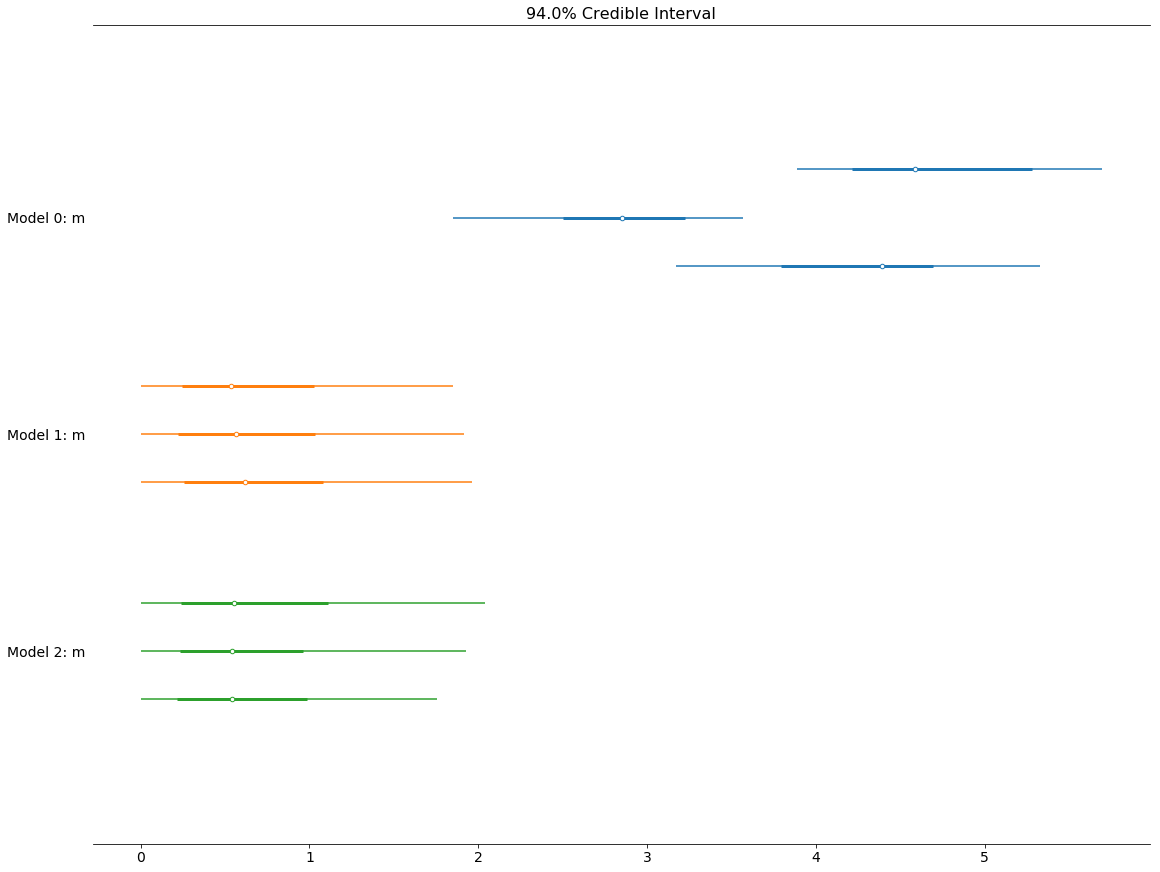

In [18]:
pm.forestplot([t_1, t_2, t_3], figsize=(16, 12))
pass

# Acceptance rate
The acceptance rate is given by the fraction of iterations where the Markov chain moved from the previous state to a new one according to the proposal distribution.

\begin{equation*}
acceptance\>rate=\frac{\#\>accepted\>candidate\>samples}{\#\>iterations}
\end{equation*}

We usually are looking for an acceptance rate between 0.23 and 0.5 when we are working with a random walk Metropolis-Hastings algorithm.
Too low acceptance rate means that the chain remains stuck at a single value for quite a long time and thus we would need a higher candidate standard deviation. On the other hand, too high acceptance rate means that the candidate standard deviation is extremely low and the chain wanders.

In [19]:
print('Model 0: acc_rate = '+str(step_1.accepted/(niter*nchains)))
print('Model 1: acc_rate = '+str(step_2.accepted/(niter*nchains)))
print('Model 2: acc_rate = '+str(step_3.accepted/(niter*nchains)))

Model 0: acc_rate = 0.9822
Model 1: acc_rate = 0.14646666666666666
Model 2: acc_rate = 0.4688


# Autocorrelation plot
When dealing with a Markov Chain, *i.e.* a sequence of random variables, we come into contact with the concept of autocorrelation.
The autocorrelation function (ACF) between two variables $X_t$ and $X_{t+h}$ is defined as:

\begin{equation*}
    ACF\left(X_t, X_{t+h}\right)=\frac{Cov\left(X_t, X_{t+h}\right)}{\sqrt{Var\left(X_t\right)\times Var\left(X_{t+h}\right)}}
\end{equation*}

where the covariance $Cov\left(X_t, X_{t+h}\right)=\mathbf{E}\left[\left(X_t-\bar{X}_t\right)\left(X_{t+h}-\bar{X}_{t+h}\right)\right]$ is a measure of the joint variability of two random variables.

Correlation is often more useful than covariance because it is standardized to be between −1 and 1, which makes it interpretable as a standard measure of linear relationship between any two variables.

If the sequence is stationary, so that the joint distribution does not change with shifts, the autocorrelation for two variables $X_t$ and $X_{t+h}$ depends on the distance $h$ between them, called lag.

We would expect the $h$-th lag autocorrelation to be smaller as $h$ increases. If autocorrelation is still relatively high for higher values of $h$, this indicates high degree of correlation between our draws.

Autocorrelation makes a great difference in how much information we get out of our Markov chains.

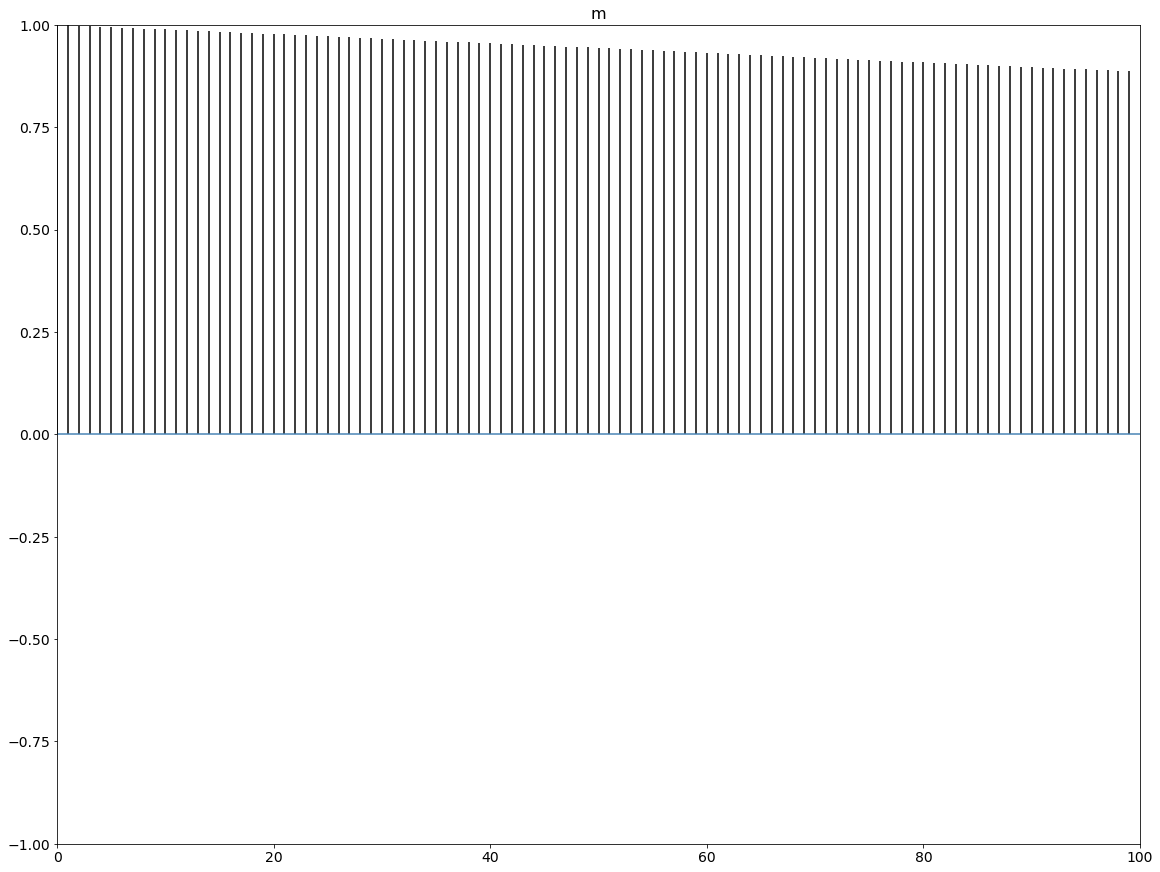

In [20]:
pm.autocorrplot(t_1, var_names=['m'], combined=True)
pass

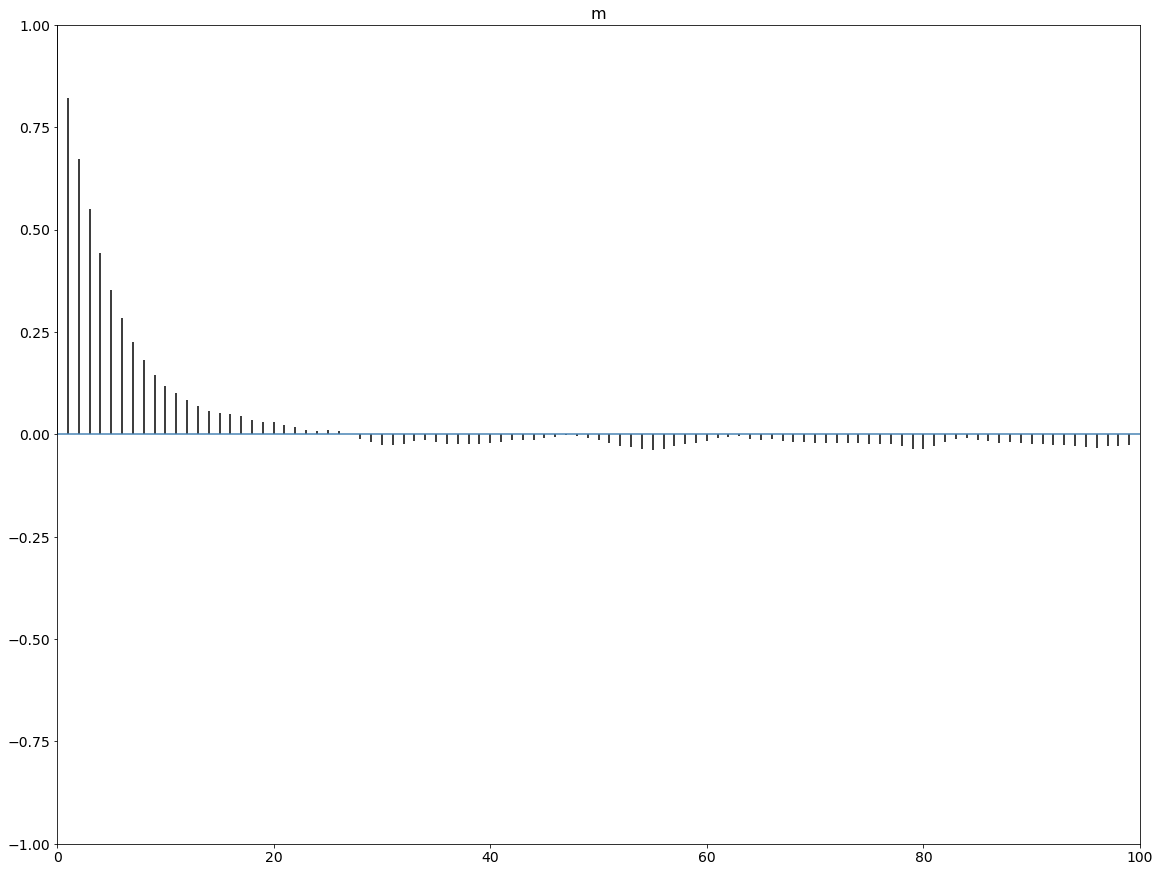

In [21]:
pm.autocorrplot(t_2, var_names=['m'], combined=True)
pass

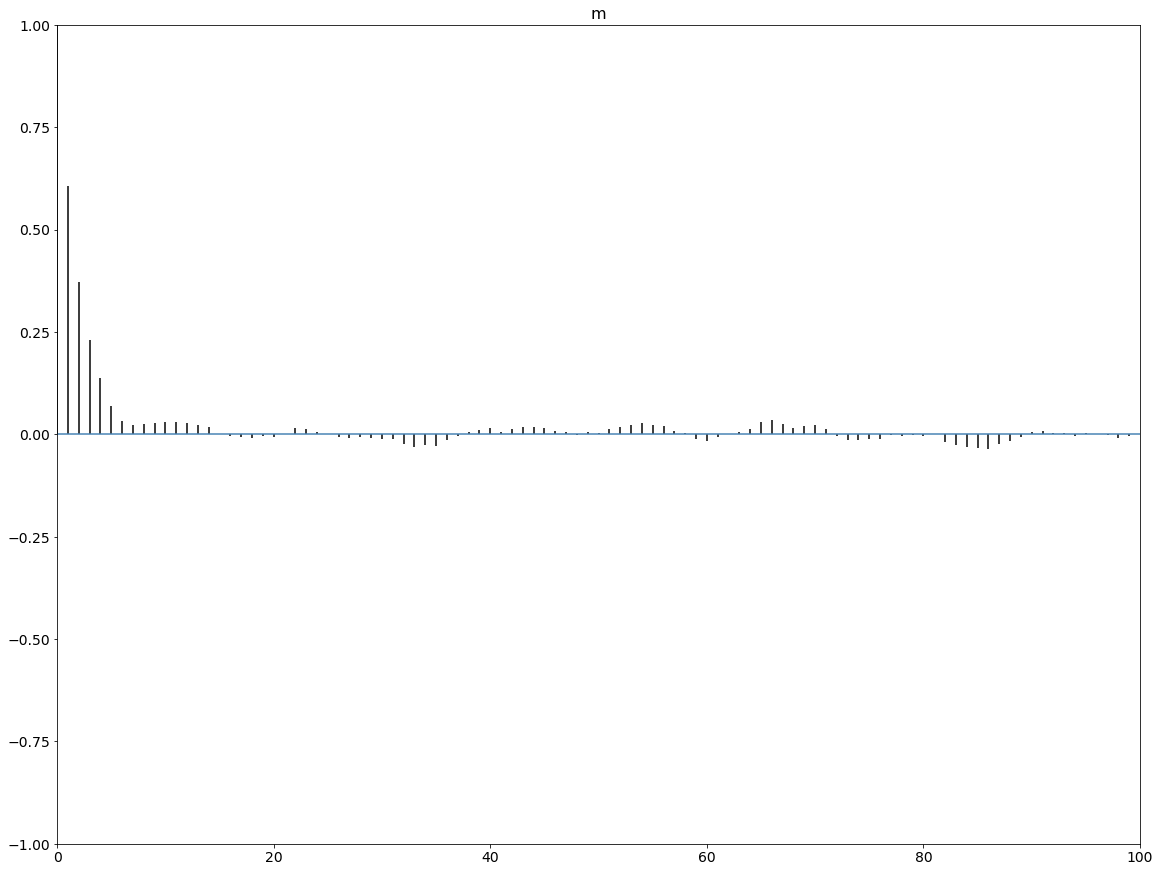

In [22]:
pm.autocorrplot(t_3, var_names=['m'], combined=True)
pass

# Effective sample size
The Monte Carlo effective sample size tells us how many independent samples from the stationary distribution we would need to get equivalent information from the Markov Chain. It is defined as following:

\begin{equation*}
\hat{n}_{eff}=\frac{mn}{1 + 2 \sum_{t=1}^T \hat{\rho}_t}
\end{equation*}

where 
- $m$ is the number of chains, 
- $n$ is the number of iterations per chain,
- $T$ is the time when the autocorrelation first becomes negative
- $\hat{\rho}_t$ is the autocorrelation at lag $t$.

In [23]:
print(pm.effective_n(t_1))
print(pm.effective_n(t_2))
print(pm.effective_n(t_3))

{'m': 2.3272034840167497}
{'m': 927.8815744942975}
{'m': 2085.5865921515788}


# Gelman-Rubin diagnostic
The Gelman-Rubin diagnostic uses an analysis of variance approach to assessing convergence. It compares the variance between multiple chains, B, to the variance within each chain, W, assessing whether they are different enough to worry about convergence. It is defined as:

\begin{equation*}
\hat{R}=\sqrt{\frac{\hat{V}(\theta|data)}{W}}=\sqrt{\frac{1}{W}\left[\left(1-\frac{1}{n}\right)W+\frac{1}{n}B\right]},
\end{equation*}
where:
- $\hat{V}(\theta|data)$ is the posterior variance estimate, derived as a weighted sum of W and B,
- $n$ is the number of iterations in each chain.

$\hat{R}$ is referred to as the potential scale reduction factor and it converges to unity when each of the traces is a sample from the target posterior. Values greater than one indicate that one or more chains have not yet converged.

In [24]:
print(pm.gelman_rubin(t_1))
print(pm.gelman_rubin(t_2))
print(pm.gelman_rubin(t_3))

{'m': 2.0739631836511903}
{'m': 1.0011480746808865}
{'m': 1.0010807402051431}


# Geweke diagnostic
The Geweke diagnostics aims to compare an early portion of the chain (usually 10%) with a late portion (usually 50%) to verify that the distributions are similar enough. It is a test on the burn-in period: if the two means do not significantly differ, we can consider the early portion as burn-in, otherwise we need to burn more iterations from the chain.

The diagnostic consists of a two-sample T-test for the difference in means:

\begin{equation*}
    T=\frac{\bar{X}_1-\bar{X}_2}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}
\end{equation*}

With an adequately wide sample size, the T distribution can be approximated using the standard normal Z.


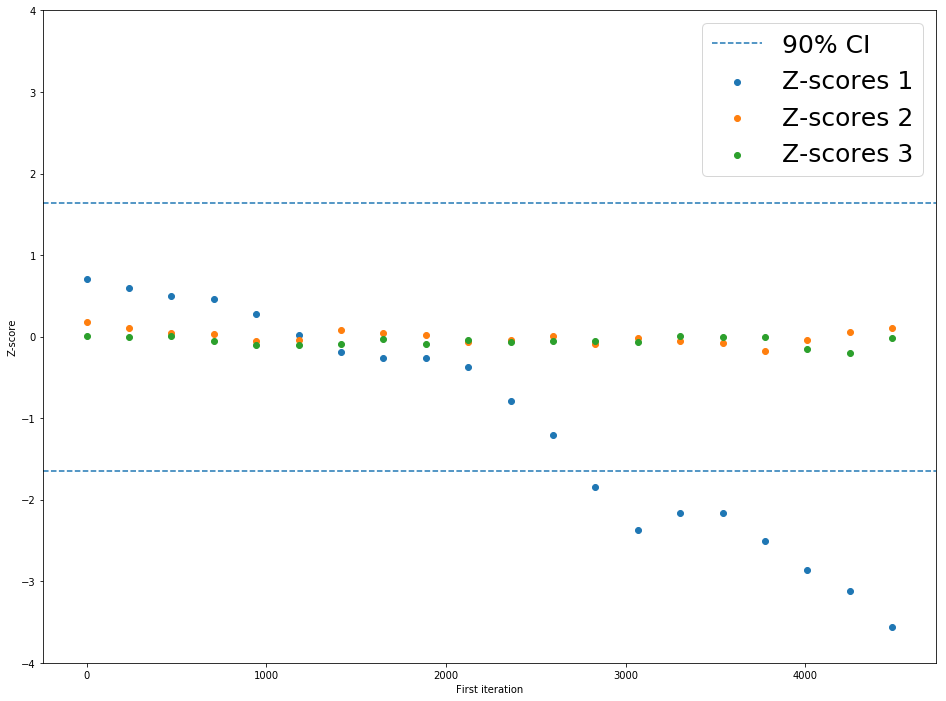

In [25]:
plt.rcParams["figure.figsize"] = (16, 12)
gew_1 = pm.geweke(t_1.m, first=.1, last=.5)
plt.scatter(gew_1[:,0], gew_1[:,1])
gew_2 = pm.geweke(t_2.m, first=.1, last=.5)
plt.scatter(gew_2[:,0], gew_2[:,1])
gew_3 = pm.geweke(t_3.m, first=.1, last=.5)
plt.scatter(gew_3[:,0], gew_3[:,1])
plt.xlabel('First iteration')
plt.ylabel('Z-score')
plt.ylim(-4, 4)
plt.axhline(-st.norm.ppf(.95), linestyle='--')
plt.axhline(st.norm.ppf(.95), linestyle='--', label='_nolegend_')
plt.legend(('90% CI', 'Z-scores 1', 'Z-scores 2', 'Z-scores 3'), bbox_to_anchor=(1,1), prop={'size': 25})
pass

# References
- https://docs.pymc.io/notebooks/api_quickstart.html
- https://docs.pymc.io/api/plots.html
- https://docs.pymc.io/api/diagnostics.html
- https://www2.math.su.se/matstat/reports/master/2011/rep2/report.pdf
- http://patricklam.org/teaching/convergence_print.pdf
-  Geweke J. Evaluating the accuracy of sampling based approaches to the calculation of posterior moments. _Bayesian Statistics 4, pp. 169-193_, 1992.

In [26]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="June 2019"></form>''')